In [1]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import zipfile
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [3]:
zf = zipfile.ZipFile('C:/Users/Serueja/Downloads/tabular-playground-series-sep-2022.zip')
test = pd.read_csv(zf.open('test.csv'))
train = pd.read_csv(zf.open('train.csv'))
submission_example = pd.read_csv(zf.open('sample_submission.csv'))

**INITIAL DATA EXPLORATION**

In [4]:
train.head(20)

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
5,5,2017-01-01,Belgium,KaggleRama,Kaggle Getting Started,187
6,6,2017-01-01,Belgium,KaggleRama,Kaggle Recipe Book,158
7,7,2017-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,267
8,8,2017-01-01,France,KaggleMart,Kaggle Advanced Techniques,610
9,9,2017-01-01,France,KaggleMart,Kaggle Getting Started,463


In [5]:
train['product'].nunique()

4

In [7]:
(train.isna().any(), test.isna().any())

(row_id      False
 date        False
 country     False
 store       False
 product     False
 num_sold    False
 dtype: bool,
 row_id     False
 date       False
 country    False
 store      False
 product    False
 dtype: bool)

In [8]:
train.groupby('date')['row_id'].count()

date
2017-01-01    48
2017-01-02    48
2017-01-03    48
2017-01-04    48
2017-01-05    48
              ..
2020-12-27    48
2020-12-28    48
2020-12-29    48
2020-12-30    48
2020-12-31    48
Name: row_id, Length: 1461, dtype: int64

In [9]:
(train.date.nunique(), test.date.nunique())

(1461, 365)

In [10]:
train[train['date'] == '2017-01-01'].head()
train['date'] = pd.to_datetime(train['date'], yearfirst=True)
train['new_date'] = train['date'].dt.to_period('M')

In [11]:
train.groupby(['country', 'store'])['num_sold'].sum()

country  store     
Belgium  KaggleMart    2064078
         KaggleRama     716972
France   KaggleMart    1865517
         KaggleRama     646802
Germany  KaggleMart    2068327
         KaggleRama     718088
Italy    KaggleMart    1635044
         KaggleRama     566048
Poland   KaggleMart     996597
         KaggleRama     344948
Spain    KaggleMart    1487691
         KaggleRama     515547
Name: num_sold, dtype: int64

**DATA VISUALIZATION**

Here we can see that probably we need to log(x+1) our sales in order to put it through regression models



Also we can notice similarities in our store sales distribution, probably we would need same function to transform the data into normal distribution 

<AxesSubplot:>

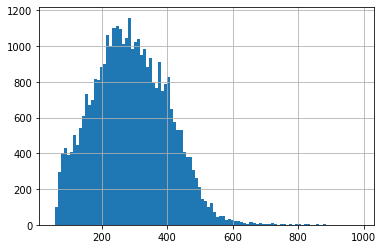

In [12]:
train[train['store'] == 'KaggleMart']['num_sold'].hist(bins=100)

<AxesSubplot:>

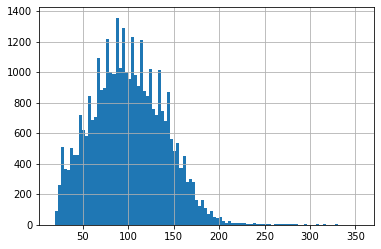

In [13]:
train[train['store'] == 'KaggleRama']['num_sold'].hist(bins=100)

<AxesSubplot:xlabel='store'>

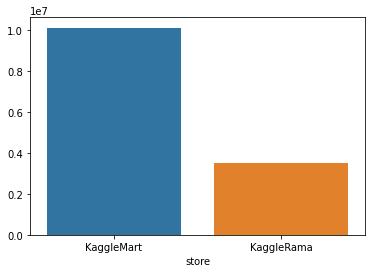

In [14]:
country_sales = train.groupby('country')['num_sold'].sum()

country_sales.sort_values(inplace=True)
sns.barplot(x=country_sales.index, y=country_sales.values)
store_sales = train.groupby('store')['num_sold'].sum()

sns.barplot(x=store_sales.index, y=store_sales.values)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    70128 non-null  int64         
 1   date      70128 non-null  datetime64[ns]
 2   country   70128 non-null  object        
 3   store     70128 non-null  object        
 4   product   70128 non-null  object        
 5   num_sold  70128 non-null  int64         
 6   new_date  70128 non-null  period[M]     
dtypes: datetime64[ns](1), int64(2), object(3), period[M](1)
memory usage: 3.7+ MB


In [16]:
books_over_time_df = []
k=train[train['product'] == 'Kaggle Advanced Techniques'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)
k=train[train['product'] == 'Kaggle Getting Started'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k) 
k=train[train['product'] == 'Kaggle Recipe Book'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)
k=train[train['product'] == 'Kaggle for Kids: One Smart Goose'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)
k=train[train['product'] == 'Kaggle Advanced Techniques'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)

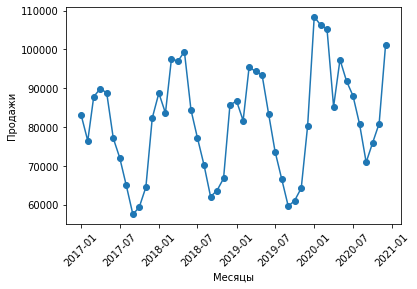

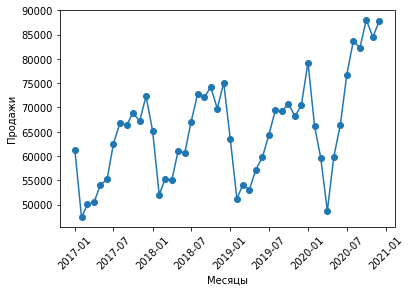

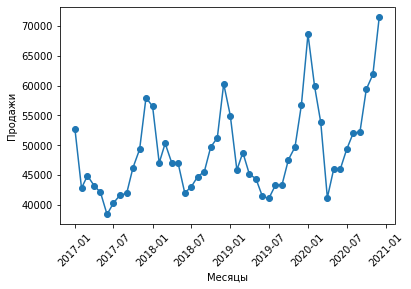

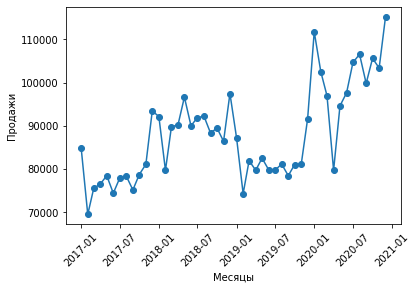

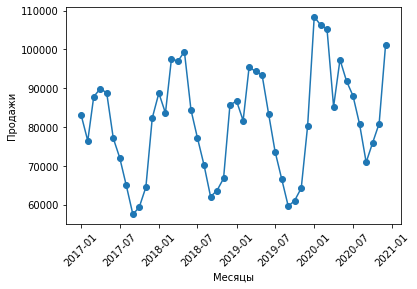

In [17]:
#fig, ax = plt.subplots(3, 2, figsize=(5 ,5))
for i in range(len(books_over_time_df)):
    plt.plot_date('new_date', 'num_sold', data = books_over_time_df[i],linestyle='solid')
    plt.xticks(rotation=45)
    plt.xlabel('Месяцы')
    plt.ylabel('Продажи')
    plt.show()

**Here we can see an obvious seasonality and trend, so we must define a trend for each book or even for each country and each book as a pair, in order to make our predictions more accurate** 

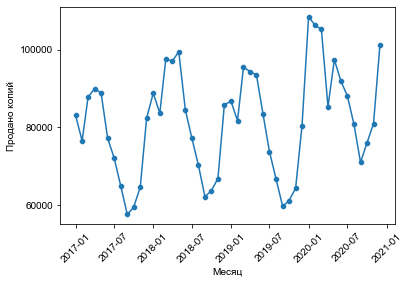

In [18]:
books_over_time_df[0]['new_date'] = books_over_time_df[0]['new_date'].astype('datetime64')
ax = sns.lineplot(data=books_over_time_df[0], x = 'new_date', y = 'num_sold')
sns.scatterplot(data=books_over_time_df[0], x = 'new_date', y = 'num_sold', ax=ax)
ax.set(xlabel='Месяц', ylabel='Продано копий')
sns.set(rc={"figure.figsize":(5, 5)}, font_scale=2)
plt.xticks(rotation=45)
plt.show()

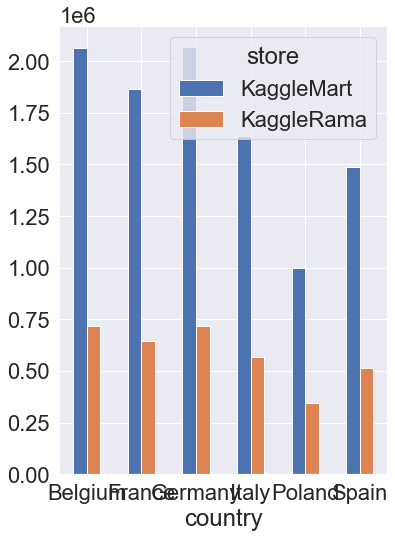

In [22]:
country_store_sales = train.groupby(['store', 'country'])['num_sold'].sum()
country_store_sales.sort_values(inplace=True)

country_store_sales
ax = country_store_sales.unstack(level=0).plot(kind='bar', subplots=False, rot=0, figsize=(6, 8), layout=(4, 6))
plt.tight_layout()

Let's see what out sales would actually look like if we apply log(x+1)

And obviously we need to really know what distribution this is

<AxesSubplot:>

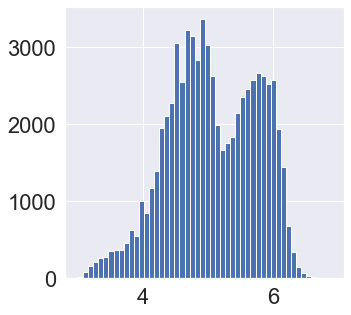

In [24]:
from math import log

log_sales = train['num_sold'].apply(lambda x: log(x+1))
log_sales.hist(bins=50)

Doesn't seem like normal distribution to me. Anyway we got to know the distribution

In [25]:
from scipy import stats

test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train['num_sold'])
normal = normal.apply(test_normality)
print(not normal.any())

False


c:\Users\Serueja\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


It is in fact a non-normal distribution, but we got here a time series, therefore we shouldn't care about the distribution of sales over time, but concentrate on finding seasonality and trend for each and every book sales

**Lets devide our dataset into 48 different sections, for each country, store, and product**

**FEATURE ENGINEERING**

In [ ]:
# train = pd.get_dummies(train, columns=['country', 'store', 'product'])
# test = pd.get_dummies(test, columns=['country', 'store', 'product'])